In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max, sum, min, rank, regexp_extract
from pyspark.sql import functions as F
from pyspark.sql.window import Window
spark = SparkSession.builder.getOrCreate()

In [5]:
cars = spark.read.csv("output.csv", header=True, inferSchema=True)

In [2]:
#GOAL 1
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, max, sum, min, rank, regexp_extract
from pyspark.sql import functions as F
from pyspark.sql.window import Window
spark = SparkSession.builder.getOrCreate()
cars = spark.read.csv("output.csv", header=True, inferSchema=True)
# Ensure the 'Mileage' column is in a consistent numerical format
# This regex extracts the numerical part from the 'Mileage' column assuming a format like "18 kmpl"
cars = cars.withColumn("Mileage_km_per_liter", regexp_extract(col("Mileage"), "(\d+.\d+)", 1).cast("float"))

# Group by 'Fuel_Type' and calculate average mileage
average_mileage_by_fuel_type = cars.groupBy("Fuel_Type").avg("Mileage_km_per_liter").withColumnRenamed("avg(Mileage_km_per_liter)", "Average_Mileage")

# Show the result
average_mileage_by_fuel_type.show()

# Note: This code assumes your Spark environment is correctly set up and 'df' is your DataFrame name.

+---------+------------------+
|Fuel_Type|   Average_Mileage|
+---------+------------------+
|   Diesel| 18.63360589785987|
|      CNG|25.445645163136145|
| Electric|              17.0|
|      LPG| 18.69583336512248|
|   Petrol|17.433374443771246|
+---------+------------------+



In [7]:
# Convert the Spark DataFrame to a Pandas DataFrame
average_mileage_by_fuel_type_pd = average_mileage_by_fuel_type.toPandas()


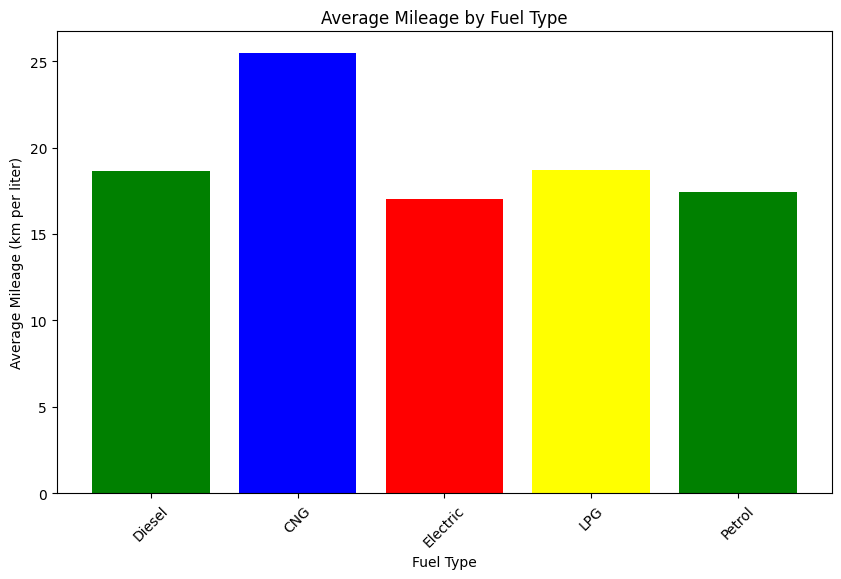

In [13]:
# GOAL1 GRAPH
import matplotlib.pyplot as plt

# Ensure the figures include inline in Jupyter notebooks
%matplotlib inline

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(average_mileage_by_fuel_type_pd['Fuel_Type'], average_mileage_by_fuel_type_pd['Average_Mileage'], color=['green','blue','red','yellow'])  # Create a bar chart
plt.xlabel('Fuel Type')  # X-axis label
plt.ylabel('Average Mileage (km per liter)')  # Y-axis label
plt.title('Average Mileage by Fuel Type')  # Chart title
plt.xticks(rotation=45)  # Rotate X-axis labels for better readability
plt.show()  # Display the plot


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize Spark Session
spark = SparkSession.builder.appName("Identifying Underpriced Cars").getOrCreate()
# Load the data
df = spark.read.csv('output.csv', header=True, inferSchema=True)
# Data cleaning and preparation
df = df.withColumn('Mileage', regexp_replace('Mileage', ' kmpl| km/kg', '').cast('float'))
df = df.withColumn('Engine', regexp_replace('Engine', ' CC', '').cast('int'))
df = df.withColumn('Power', regexp_replace('Power', ' bhp', '').cast('float'))
# Handle missing values
df = df.na.drop(subset=['Mileage', 'Engine', 'Power', 'Price'])
# Feature Engineering: Encoding categorical variables
stringIndexer = StringIndexer(inputCols=['Fuel_Type', 'Transmission', 'Owner_Type'], 
                              outputCols=['Fuel_Type_Indexed', 'Transmission_Indexed', 'Owner_Type_Indexed'])
oneHotEncoder = OneHotEncoder(inputCols=['Fuel_Type_Indexed', 'Transmission_Indexed', 'Owner_Type_Indexed'], 
                               outputCols=['Fuel_Type_Vec', 'Transmission_Vec', 'Owner_Type_Vec'])
# Assembling all features into a single vector
assembler = VectorAssembler(inputCols=['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 
                                       'Fuel_Type_Vec', 'Transmission_Vec', 'Owner_Type_Vec'], 
                            outputCol="features")
# Random Forest Regression Model
rf = RandomForestRegressor(featuresCol="features", labelCol="Price")
# Pipeline
pipeline = Pipeline(stages=[stringIndexer, oneHotEncoder, assembler, rf])
# Split the data into training and test sets
trainData, testData = df.randomSplit([0.8, 0.2])
# Fit the model
model = pipeline.fit(trainData)
# Make predictions
predictions = model.transform(testData)
# Evaluate the model
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")
# Identifying underpriced cars
underpriced_cars = predictions.withColumn("Price_Difference", col("Price") - col("prediction"))
underpriced_cars = underpriced_cars.filter(col("Price_Difference") > 0).select("Name", "Year", "Price", "prediction", "Price_Difference")
# Save underpriced cars to CSV
underpriced_cars.write.option("header", "true").mode("overwrite").csv("underpriced_cars.csv")
# Save the DataFrame to a CSV file
predictions.withColumn("Price_Difference", predictions["Price"] - predictions["prediction"]) \
    .select("Name", "Year", "Price", "prediction", "Price_Difference") \
    .coalesce(1) \
    .write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv("underpriced_cars_output.csv")

Root Mean Squared Error (RMSE) on test data: 5.317164294643757


In [9]:
# GOAL 3:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("MarketSegmentation").getOrCreate()

# Load data
data = spark.read.csv("output.csv", header=True, inferSchema=True)

# Group by Owner Type and count the number of records in each segment
segment_counts = data.groupBy("Owner_Type").count().orderBy("Owner_Type")

# Display the counts for each segment
segment_counts.show()

# You can perform further analysis or visualization on each segment as needed


+--------------+-----+
|    Owner_Type|count|
+--------------+-----+
|         First| 5952|
|Fourth & Above|   12|
|        Second| 1152|
|         Third|  137|
+--------------+-----+



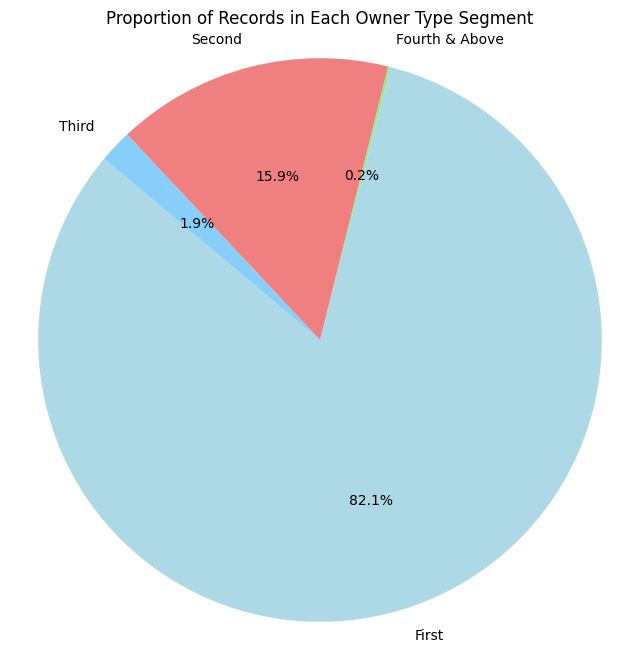

In [15]:
# GOAL3 GRAPH
import matplotlib.pyplot as plt

# Extracting data for plotting
owner_types = segment_counts.select("Owner_Type").rdd.flatMap(lambda x: x).collect()
counts = segment_counts.select("count").rdd.flatMap(lambda x: x).collect()

# Creating the pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=owner_types, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Proportion of Records in Each Owner Type Segment')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Displaying the plot
plt.show()


In [6]:
# prints price and predictions in csv file
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
# Initialize Spark Session
spark = SparkSession.builder.appName("Price Elasticity Analysis").getOrCreate()
# Load the data
df = spark.read.csv('output.csv', header=True, inferSchema=True)
# Data cleaning and preparation
df = df.withColumn('Mileage', regexp_replace('Mileage', ' kmpl| km/kg', '').cast('float'))
df = df.withColumn('Engine', regexp_replace('Engine', ' CC', '').cast('int'))
df = df.withColumn('Power', regexp_replace('Power', ' bhp', '').cast('float'))
# Dropping rows with any null values in 'Mileage', 'Engine', 'Power', or 'Price' columns
df = df.na.drop(subset=['Mileage', 'Engine', 'Power', 'Price'])
# Feature Engineering: Encoding categorical variables
stringIndexer = StringIndexer(inputCols=['Fuel_Type', 'Transmission', 'Owner_Type'], 
                              outputCols=['Fuel_Type_Indexed', 'Transmission_Indexed', 'Owner_Type_Indexed'])
oneHotEncoder = OneHotEncoder(inputCols=['Fuel_Type_Indexed', 'Transmission_Indexed', 'Owner_Type_Indexed'], 
                               outputCols=['Fuel_Type_Vec', 'Transmission_Vec', 'Owner_Type_Vec'])
# Assembling all features into a single vector
assembler = VectorAssembler(inputCols=['Mileage', 'Engine', 'Power', 'Fuel_Type_Vec', 'Transmission_Vec', 'Owner_Type_Vec'], 
                            outputCol="features")
# Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="Price")
# Pipeline
pipeline = Pipeline(stages=[stringIndexer, oneHotEncoder, assembler, lr])
# Split the data into training and test sets
trainData, testData = df.randomSplit([0.7, 0.3])
# Fit the model
model = pipeline.fit(trainData)
# Make predictions
predictions = model.transform(testData)
# Select only the 'Price' and 'prediction' columns
selectedData = predictions.select("Price", "prediction")
# Save the selected data to CSV
selectedData.coalesce(1).write.option("header", "true").mode("overwrite").csv("price_predictions_output.csv")
# Model evaluation
evaluator = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print(f"R2 on test data: {r2}")

R2 on test data: 0.5325145861079235


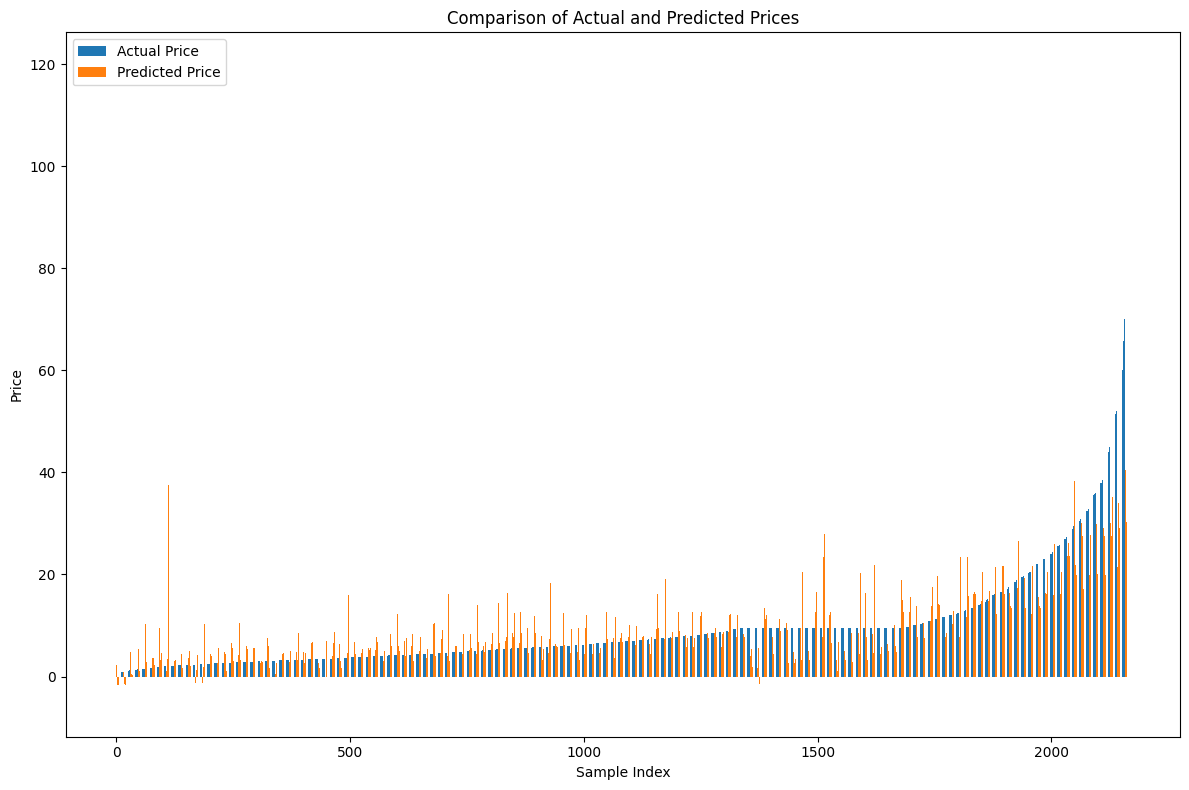

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming the Spark DataFrame 'selectedData' already contains the 'Price' and 'prediction' columns
# Convert Spark DataFrame to Pandas DataFrame
prediction_data = selectedData.toPandas()

# Sort data to better visualize comparisons
prediction_data = prediction_data.sort_values(by='Price').reset_index(drop=True)

# Plotting
plt.figure(figsize=(12, 8))
# Creating indices for each pair of bars
index = prediction_data.index
bar_width = 0.35

# Actual Prices Bar
plt.bar(index, prediction_data['Price'], bar_width, label='Actual Price')

# Predicted Prices Bar
plt.bar(index + bar_width, prediction_data['prediction'], bar_width, label='Predicted Price')

plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.title('Comparison of Actual and Predicted Prices')
plt.legend()
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()


In [8]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, year, regexp_replace

# Initialize Spark Session
spark = SparkSession.builder.appName("Car Price Trend Analysis").getOrCreate()

# Load the data
df = spark.read.csv('output.csv', header=True, inferSchema=True)

# Data cleaning
# Convert 'New_Price' to a numeric format. Assuming 'New_Price' is like '1.5 Lakh' or '10.5 Crore'
# For simplicity, let's just handle 'Lakh' and assume 'Crore' is not present or handled separately
df = df.withColumn('New_Price_Num', regexp_replace('New_Price', ' Lakh', '').cast('float') * 100000)

# Analyzing trends in Price over time
# Group by 'Year', calculate average 'Price', and average 'New_Price_Num'
price_trends = df.groupBy('Name', 'Year').agg(
    avg(col('Price')).alias('Average_Price')
).orderBy('Year')

# Show the results
price_trends.coalesce(1).write.mode('overwrite').csv('trend_analysis_output.csv', header=True)
